In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [3]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


Посмотрим описательные статистики выручки у начального датасета и взятого по срезам.

In [5]:
df['revenue_amount'].describe()

count    8.625842e+06
mean     4.009047e+02
std      9.602217e+02
min      1.000000e+00
25%      8.800000e+01
50%      1.670000e+02
75%      4.050000e+02
max      2.881230e+05
Name: revenue_amount, dtype: float64

In [17]:
df_seg = df.groupby(['user_segment']).agg({'revenue_amount': 'mean'}) #агрегируем по сегменту
df_seg.describe()

,revenue_amount
count,3.000000
mean,567.902144
std,466.090091
min,207.760172
25%,304.688064
50%,401.615956
75%,747.973130
max,1094.330305


[(100.0, 1200.0)]

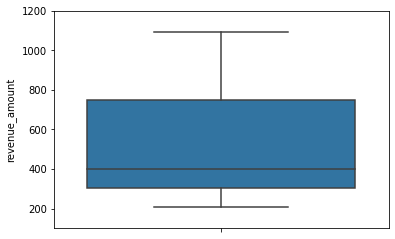

In [20]:
ax = sns.boxplot(y = df_seg['revenue_amount'], orient = 'v')
ax.set(ylim = (100,1200))

In [18]:
df_cat = df.groupby(['category']).agg({'revenue_amount': 'mean'}) #агрегируем по категории
df_cat.describe()

,revenue_amount
count,33.000000
mean,427.308587
std,336.174781
min,136.595029
25%,233.014721
50%,352.174948
75%,497.431001
max,1955.979431


[(100.0, 2000.0)]

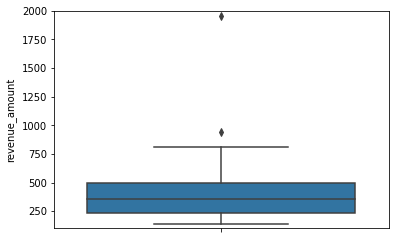

In [22]:
ax = sns.boxplot(y = df_cat['revenue_amount'], orient = 'v')
ax.set(ylim = (100,2000))

In [19]:
df_reg = df.groupby(['region']).agg({'revenue_amount': 'mean'}) #агрегируем по региону
df_reg.describe()

,revenue_amount
count,84.000000
mean,299.283940
std,94.141554
min,182.157253
25%,237.126174
50%,282.286679
75%,336.866921
max,709.130762


[(100.0, 800.0)]

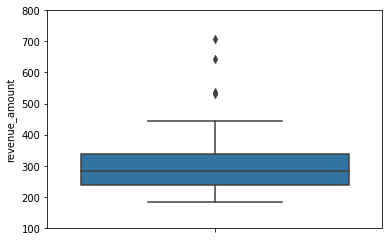

In [24]:
ax = sns.boxplot(y = df_reg['revenue_amount'], orient = 'v')
ax.set(ylim = (100,800))

Посчитаем MDE для групп 10, 25 и 50% за 30, 60 и 90 дней.

In [28]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x

In [44]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),30,10) #получаем необходимую подвыборку, берем 10% пользователей на 30 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0378 #точность без CUPED ~ 0.0378
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9984348222717511


In [51]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),60,10) #получаем необходимую подвыборку, берем 10% пользователей на 60 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9951646897591964


In [56]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),90,10) #получаем необходимую подвыборку, берем 10% пользователей на 90 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9970594028073315


In [62]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),30,25) #получаем необходимую подвыборку, берем 25% пользователей на 30 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0378 #точность без CUPED ~ 0.0378
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9984348222717511


In [65]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),60,25) #получаем необходимую подвыборку, берем 25% пользователей на 60 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9951646897591964


In [68]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),60,25) #получаем необходимую подвыборку, берем 25% пользователей на 90 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9951646897591964


In [72]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),30,50) #получаем необходимую подвыборку, берем 50% пользователей на 30 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0378 #точность без CUPED ~ 0.0378
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9984348222717511


In [74]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),60,50) #получаем необходимую подвыборку, берем 50% пользователей на 60 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9951646897591964


In [76]:
x1 =choose_date(df, datetime.datetime(2019, 6, 18, 0, 0),90,50) #получаем необходимую подвыборку, берем 50% пользователей на 90 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.0372 #точность без CUPED ~ 0.0372
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9970594028073315


Попробуем посмотреть на целевую метрику после применения CUPED и на изменение MDE для групп 50/50 на 30 дней.

In [268]:
#Предположим, что данные собирались месяц с начальной даты до 18 июля, эксперимент проводится на следующий день до 18 августа.

df_pre = df[(df['event_date'] >= '2019-06-18') & (df['event_date'] < '2019-07-18')]
df_exp = df[(df['event_date'] >= '2019-07-18') & (df['event_date'] < '2019-08-17')]

In [269]:
df_all = pd.merge(df_exp, df_pre,  how='left', left_on=['user_id',df_exp['event_date'] - datetime.timedelta(days=30)], right_on=['user_id','event_date'])

In [270]:
df_all = df_all.drop(['event_date', 'event_date_y', 'user_segment_y', 'category_y', 'region_y'], axis = 1)

In [271]:
df_all['revenue_amount_y'] = df_all['revenue_amount_y'].fillna(0)

In [272]:
df_all = df_all.drop_duplicates()

In [236]:
df_all['pre_revenue_average'] = df_all.revenue_amount_y.mean() #среднее предданых

C:\Users\vladk\AppData\Local\Temp/ipykernel_5324/905822839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['pre_revenue_average'] = df_all.revenue_amount_y.mean() #среднее предданых


In [238]:
teta = np.cov(df_all.revenue_amount_x,df_all.revenue_amount_y, ddof=1)[1,0]/np.var(df_all.revenue_amount_y, ddof=1) #Множитель CUPED

In [239]:
corr = np.corrcoef(df_all.revenue_amount_x,df_all.revenue_amount_y)[1,0]

In [240]:
df_all['cuped_revenue'] = df_all.revenue_amount_x - teta * (df_all.revenue_amount_y - df_all.pre_revenue_average) #CUPED-выручка

C:\Users\vladk\AppData\Local\Temp/ipykernel_5324/2338430526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['cuped_revenue'] = df_all.revenue_amount_x - teta * (df_all.revenue_amount_y - df_all.pre_revenue_average) #CUPED-выручка


In [253]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date_x>=start_date)&(data.event_date_x<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x



x1 =choose_date(df_all, datetime.datetime(2019, 7, 19, 0, 0),30,50) #получаем необходимую подвыборку, берем 50% пользователей на 30 дней


mean = x1.cuped_revenue.mean()
std = x1.cuped_revenue.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.121 #точность с CUPED ~ 0.121
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9966382576300521


In [140]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date>=start_date)&(data.event_date<=start_date+datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id)%100<=100*share].reset_index()
    return x


x1 =choose_date(df, datetime.datetime(2019, 7, 19, 0, 0),30,50) #получаем необходимую подвыборку, берем 50% пользователей на 30 дней


mean = x1.revenue_amount.mean()
std = x1.revenue_amount.std()
 
alpha = 0.01
power = 0.8
result_effect = 0.039 #точность без CUPED ~ 0.039
effect_size = (mean /std) * result_effect
 
    
sample_vol = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1, alternative = 'two-sided')    
print(sample_vol/x1.shape[0])

0.9948237737605128


CUPED очень сильно снижает точность, возможно, что это вызвано сезонными эффектами.